## Notebook for training GPR on DC dataset and generating set of suggestions

**Created on 10th August, 2023; modified on 17th April, 2024**

**Dataset: label_ecfp_pca_add_feat_082423.csv**

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
## import train_test_split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, Matern, ConstantKernel, DotProduct, PairwiseKernel 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import SVG, display

import json
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
output_notebook()

Loading BokehJS ...

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-7
total 2864
-rw-r--r--@ 1 riteshk  staff  1462464 May 11 13:24 sugg_gpr_bma_iter_7.ipynb


Finding smiles that have been labeled

In [29]:
df_unlabel = pd.read_csv('../campaign-6/unlabel_1mil_ecfp_pca_add_feat_iter_6.csv') ## unlabeled data created from iteration-6; initial unlabeled data (~1 mil)
df_unlabel.rename(columns={'Unnamed: 0':'index_4'}, inplace=True) ## change index accordingly, but original index is in index_0 column
df_unlabel

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999851,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999852,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999853,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999854,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [4]:
def get_row(ind):
    sm = df_unlabel.loc[df_unlabel['index_0'] == ind]['solv_comb_sm']
    return df_unlabel.loc[df_unlabel['solv_comb_sm'] == sm.values[0]]

In [29]:
sm = Chem.MolFromSmiles('COCCOCCOCCOC')
sm = Chem.MolFromSmiles('COCCOCCOCCOCCOC')
sm = Chem.MolFromSmiles('COC1CCCC1')
sm = Chem.MolFromSmiles('COCCCCCCOC')
sm = Chem.MolFromSmiles('COC(=O)C1CCCCCC1=O')
sm = Chem.MolFromSmiles('COCCOCOCCOC')
sm = Chem.MolFromSmiles('CCCCOCCOCCOC')
sm = Chem.MolFromSmiles('CCOCCOCCOC')
sm = Chem.MolFromSmiles('COC1CCCCC1=O')
sm = Chem.MolFromSmiles('COCCS(=O)(=O)F')
sm = Chem.MolFromSmiles('COCCSC')
df_unlabel.loc[df_unlabel['solv_comb_sm'] == Chem.MolToSmiles(sm)]

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
275439,275450,275459,275464,275474,275488,COCCSC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.819883,-1.431011,0.956715,...,0.258767,0.301779,-0.272648,106.045236,186.939685,1.0,0.0,150,50,2
979133,979164,979190,979206,979236,979274,COCCSC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.819883,-1.431011,0.956715,...,0.008496,0.161338,0.109063,106.045236,144.001775,1.0,0.0,150,50,2


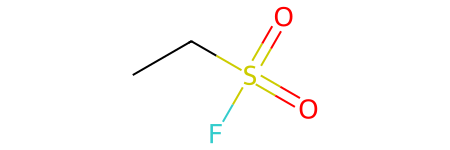

In [110]:
Chem.MolFromSmiles('COCCN(C)S(C)(=O)=O')
Chem.MolFromSmiles('CCS(=O)(=O)F')

In [30]:
## Finding labaled data from 6th campaign
label_iter_6 = pd.DataFrame(columns=df_unlabel.columns)
## the code below will only extract one solvent entry; but we want all three solvent entries
row_1 = get_row(52672) ## CAS: 112-49-2
row_2 = get_row(155846) ## CAS: 143-24-8
row_3 = get_row(91937) ## CAS: 5614-37-9
row_4 = get_row(208915) ## CAS: 13179-98-1
row_5 = get_row(308230) ## CAS: 52784-32-4
row_6 = get_row(113022) ## CAS: 4431-83-8
row_7 = get_row(70319) ## CAS: 7382-32-3
row_8 = get_row(18189) ## CAS: 1002-67-1
row_9 = get_row(45161) ## CAS: 7429-44-9
row_10 = get_row(69518) ## CAS: 1087410-86-3
row_11 = get_row(275488) ## CAS: 35332-09-3
label_iter_7 = pd.concat([label_iter_6, row_1, row_2, row_3, row_4, row_5, row_6, row_7, row_8, row_9, row_10, row_11], axis=0)
label_iter_7
# row_10

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
52653,52658,52663,52665,52668,52672,COCCOCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.899245,-1.039674,1.079794,...,0.258767,0.301779,-0.272648,178.120509,186.939685,1.0,0.0,150,50,2
371863,371876,371890,371898,371912,371930,COCCOCCOCCOC,[Li+].F[P-](F)(F)(F)(F)F,-0.899245,-1.039674,1.079794,...,0.195230,0.319099,-0.209425,178.120509,151.980186,1.0,0.0,150,50,2
696662,696685,696707,696719,696742,696771,COCCOCCOCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.899245,-1.039674,1.079794,...,0.008496,0.161338,0.109063,178.120509,144.001775,1.0,0.0,150,50,2
155810,155819,155826,155829,155836,155846,COCCOCCOCCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.899245,-1.039674,1.079794,...,0.258767,0.301779,-0.272648,222.146724,186.939685,1.0,0.0,150,50,2
429822,429840,429855,429864,429882,429903,COCCOCCOCCOCCOC,[Li+].F[P-](F)(F)(F)(F)F,-0.899245,-1.039674,1.079794,...,0.195230,0.319099,-0.209425,222.146724,151.980186,1.0,0.0,150,50,2
748171,748197,748220,748233,748259,748292,COCCOCCOCCOCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.899245,-1.039674,1.079794,...,0.008496,0.161338,0.109063,222.146724,144.001775,1.0,0.0,150,50,2
91912,91917,91922,91925,91931,91937,COC1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.807314,-0.951595,0.879080,...,0.258767,0.301779,-0.272648,100.088815,186.939685,1.0,0.0,150,50,2
401585,401602,401616,401625,401642,401662,COC1CCCC1,[Li+].F[P-](F)(F)(F)(F)F,0.807314,-0.951595,0.879080,...,0.195230,0.319099,-0.209425,100.088815,151.980186,1.0,0.0,150,50,2
755379,755407,755431,755444,755471,755504,COC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.807314,-0.951595,0.879080,...,0.008496,0.161338,0.109063,100.088815,144.001775,1.0,0.0,150,50,2
208873,208883,208890,208894,208903,208915,COCCCCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.946328,-1.547746,0.906366,...,0.258767,0.301779,-0.272648,146.130680,186.939685,1.0,0.0,150,50,2


In [31]:
label_iter_7['solv_comb_sm'].unique()

array(['COCCOCCOCCOC', 'COCCOCCOCCOCCOC', 'COC1CCCC1', 'COCCCCCCOC',
       'COC(=O)C1CCCCCC1=O', 'COCCOCOCCOC', 'CCCCOCCOCCOC', 'CCOCCOCCOC',
       'COC1CCCCC1=O', 'COCCS(=O)(=O)F', 'COCCSC'], dtype=object)

In [32]:
df_unlabel_ = df_unlabel.drop(label_iter_7.index) ## drop the labeled molecules from the unlabeled data
df_unlabel_

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999851,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999852,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999853,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999854,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [32]:
# df_unlabel_.to_csv('unlabel_1mil_ecfp_pca_add_feat_iter_7.csv') ## save the unlabeled data for the next iteration
df_unlabel_ = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat_iter_7.csv') ## read the unlabeled data for the next iteration
# df_unlabel_

In [34]:
label_iter_7.to_csv('just_label_iter_7.csv', index=False) ## also save the labeled data from the 6th iteration of suggestions
# label_iter_5 = pd.read_csv('just_label_iter_5.csv') ## read the labeled data labeled data from the 6th iteration of suggestions
# label_iter_5

In [28]:
df = pd.read_csv('label_ecfp_pca_add_feat_iter_7_051124.csv') ## added the labeled data from the 6th iteration of suggestions to the labeled data from 4th iteration manually
df['solv_comb_sm'] = df['solv_comb_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,COC1CCCCC1=O,[Li+].F[P-](F)(F)(F)(F)F,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
195,COC1CCCCC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
196,COCCS(=O)(=O)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
197,COCCSC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [36]:
df['theor_capacity'].unique()

array([150, 203, 161])

In [3]:
## Important change: on 24th August, 2023
df_ = df.copy()
df_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,COC1CCCCC1=O,[Li+].F[P-](F)(F)(F)(F)F,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
195,COC1CCCCC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
196,COCCS(=O)(=O)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
197,COCCSC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [4]:
X = df_.iloc[:,2:27]
y = df_['norm_capacity_3']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## will be using complete dataset for training
# X_test
X

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,-0.780469,-0.407588,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,90.068080,186.939685,1.0,150,50
1,-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,-0.507040,-0.352331,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,118.099380,186.939685,1.0,150,50
2,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
3,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
4,-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,0.099267,-0.130341,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,146.130680,186.939685,2.2,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,0.203690,-0.160053,0.195230,0.319099,-0.209425,128.083730,151.980186,1.0,150,50
195,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,128.083730,144.001775,1.0,150,50
196,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,-1.061449,-0.608401,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,142.009993,186.939685,1.0,150,50
197,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,-0.907013,-0.467004,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,106.045236,186.939685,1.0,150,50


In [5]:
std_scale_ = StandardScaler().fit(X)
X_std = std_scale_.transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [6]:
kernel_1 = PairwiseKernel(metric='polynomial') + WhiteKernel(noise_level=0.1)
kernel_3 = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
kernel_2 = Matern(length_scale=0.01, nu=2.5) + WhiteKernel(noise_level=0.1)
kernel_4 = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.1)
kernel_5 = ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernel_6 = RationalQuadratic(length_scale=0.01, alpha=1.0) + WhiteKernel(noise_level=0.1)
kernel_7 = DotProduct(sigma_0=0.1) + WhiteKernel(noise_level=0.1)
kernel_8 = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernels = [kernel_1, kernel_2, kernel_3, kernel_4, kernel_5, kernel_6, kernel_7, kernel_8]
kernel_name = ['PairwiseKernel', 'Matern 5/2', 'RBF', 'Matern 3/2', 'ExpSineSquared', 'RationalQuadratic', 'DotProduct', 'RBF+ExpSineSquared']
cv_dict = {'kernel': list(), 'score': list()}

In [7]:
# def negative_log_likelihood(noise_level, length_scale, alpha, kernel_name):
# def negative_log_likelihood(params, kernel_name):
def negative_log_likelihood_rbf(params):
    noise_level, length_scale, alpha = params ## for adding regularization parameter
    # noise_level, length_scale = params ## in case of not adding regularization parameter
    # if kernel_name == 'RBF':
    kernel = RBF(length_scale=length_scale)
    # elif kernel_name == 'Matern-5/2':
        # kernel = Matern(length_scale=length_scale, nu=2.5)
    # elif kernel_name == 'Pairwise':
        # kernel = PairwiseKernel(metric='polynomial')
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    # gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=0.0, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=0) ## in case of not adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rq(params):
    noise_level, length_scale, alpha_k, alpha = params ## for adding regularization parameter
    kernel = RationalQuadratic(length_scale=length_scale, alpha=alpha_k)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rbf_expsin(params):
    noise_level, length_scale, periodicity, alpha = params ## for adding regularization parameter
    kernel = RBF(length_scale=length_scale) + ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_matern(params):
    noise_level, length_scale, alpha = params
    kernel = Matern(length_scale=length_scale, nu=1.5)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_pairwise(params):
    noise_level, length_scale, alpha = params
    kernel = PairwiseKernel(metric="polynomial")
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

**Optimize Pairwise kernel**

In [8]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_pairwise, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of i

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha: 0.0001


In [9]:
optimized_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.47963748341595125
MAE: 0.16857984261222458
RMSE: 0.21150745128650272


In [10]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

PairwiseKernel(gamma=0.0006826987266972126, metric=polynomial) + WhiteKernel(noise_level=0.0488)

In [11]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.361177,0.223832
1,0.661460,0.270491,0.226386
2,0.178387,0.311420,0.226703
3,0.216953,0.311420,0.226703
4,0.026187,0.464290,0.233014
...,...,...,...
194,0.000000,0.162861,0.231451
195,0.000000,0.147733,0.232369
196,0.264730,0.376238,0.224566
197,0.000000,0.394573,0.224342


**Optimize RationalQuadratic kernel**

In [12]:
initial_guess = [0.15, 0.01, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha_k, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha_k, alpha
result = minimize(negative_log_likelihood_rq, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha_k, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha_k:", optimized_alpha_k)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warning

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha_k: 0.01
Optimized alpha: 0.020000014748940875


In [13]:
optimized_kernel = RationalQuadratic(length_scale=optimized_length_scale, alpha=optimized_alpha_k) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.5812358190486879
MAE: 0.14166667481286438
RMSE: 0.18973936064426863


In [14]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RationalQuadratic(alpha=0.0532, length_scale=18.5) + WhiteKernel(noise_level=0.0233)

In [15]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.356559,0.161459
1,0.661460,0.265441,0.165826
2,0.178387,0.289472,0.166569
3,0.216953,0.289472,0.166569
4,0.026187,0.399959,0.184328
...,...,...,...
194,0.000000,0.158539,0.181804
195,0.000000,0.151038,0.183952
196,0.264730,0.348684,0.162230
197,0.000000,0.361483,0.161759


**Optimize Matern-3/2 kernel**

In [16]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_matern, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha: 0.008782600945730268


In [17]:
optimized_kernel = Matern(length_scale=optimized_length_scale, nu=1.5) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.5438012744857356
MAE: 0.1520157812744019
RMSE: 0.19803853414025485


In [18]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

Matern(length_scale=32.1, nu=1.5) + WhiteKernel(noise_level=0.0364)

In [19]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.360720,0.196334
1,0.661460,0.268475,0.199613
2,0.178387,0.301687,0.200114
3,0.216953,0.301687,0.200114
4,0.026187,0.453333,0.211222
...,...,...,...
194,0.000000,0.163079,0.209146
195,0.000000,0.152526,0.211345
196,0.264730,0.367228,0.197017
197,0.000000,0.380833,0.196771


**Optimize RBF-ExpineSquared kernel**

In [20]:
initial_guess = [0.15, 0.01, 1.0, 0.02] # initial guess for noise_level, length_scale, periodicity, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-2, 10.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, periodicity, alpha
result = minimize(negative_log_likelihood_rbf_expsin, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_periodicity, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized periodicity:", optimized_periodicity)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of i

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized periodicity: 1.0
Optimized alpha: 0.019990551711914106


In [21]:
optimized_kernel = RBF(length_scale=optimized_length_scale) + ExpSineSquared(length_scale=optimized_length_scale, periodicity=optimized_periodicity) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.5258653641391808
MAE: 0.15905145714367064
RMSE: 0.2018940454245666


In [22]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RBF(length_scale=19.1) + ExpSineSquared(length_scale=36.5, periodicity=0.00355) + WhiteKernel(noise_level=0.0382)

In [23]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.425807,0.199163
1,0.661460,0.300381,0.203989
2,0.178387,0.247460,0.204200
3,0.216953,0.247460,0.204200
4,0.026187,0.422037,0.213558
...,...,...,...
194,0.000000,0.153704,0.211799
195,0.000000,0.125004,0.213045
196,0.264730,0.403620,0.200165
197,0.000000,0.302719,0.199563


**Production runs**

In [33]:
# df_unlabel = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat.csv')
# df_unlabel_ = df_unlabel.copy()
df_unlabel_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_unlabel_

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1,150,50
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1,150,50
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1,150,50
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1,150,50
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,193.077264,144.001775,1,150,50
999822,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,240.147392,144.001775,1,150,50
999823,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,251.046358,144.001775,1,150,50
999824,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,248.133634,144.001775,1,150,50


In [34]:
# uniq_smiles = df_unlabel_['smiles'].unique()
df_unlabel_uniq = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
df_unlabel_uniq

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1,150,50
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1,150,50
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1,150,50
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1,150,50
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999811,999872,999899,999915,999946,999984,CCCCN1C(=O)OCC1[SiH](C)C,[Li+].O=C1O[B-](F)(F)OC1=O,0.627609,-0.998588,-0.085111,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,201.118505,144.001775,1,150,50
999813,999874,999901,999917,999948,999986,CC(C)(C)C(=O)N1C2CCC1COC2,[Li+].O=C1O[B-](F)(F)OC1=O,0.902927,0.033572,0.856049,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,197.141579,144.001775,1,150,50
999814,999875,999902,999918,999949,999987,CC(C)(C)C(=O)CS(=O)(=O)CC(=O)N1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.621175,0.407378,0.570353,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,275.119129,144.001775,1,150,50
999815,999876,999903,999919,999950,999988,CCO[Si](CCC(C)SC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.112749,-1.140740,0.140488,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,238.105892,144.001775,1,150,50


In [35]:
# df_unlabel_.drop(columns=['Unnamed: 0'], inplace=True)
X_un = df_unlabel_.iloc[:,7:] ## change it for every new iteration
X_un_std = std_scale_.transform(X_un)
X_un_std = pd.DataFrame(X_un_std, columns=X_un.columns)
# X_std = std_scale_.transform(X)
# X_std = pd.DataFrame(X_std, columns=X.columns)
X_un_std

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0.189971,0.522984,-2.384489,-0.251395,1.921232,-0.583037,-0.892321,0.042383,-1.134547,0.309934,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-1.436471,0.585522,-0.259754,-0.26585,0.19753
1,1.885197,0.623655,-0.099303,1.634960,1.410758,-2.588613,-0.360440,1.314070,-1.163256,0.259675,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-0.692647,0.585522,-0.259754,-0.26585,0.19753
2,-0.121483,2.530338,-2.007775,-0.198407,2.648947,-0.785415,-1.079594,-0.057542,-1.111984,0.360352,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-0.656103,0.585522,-0.259754,-0.26585,0.19753
3,0.408186,-0.285855,-0.260020,0.193311,1.505732,-1.221817,-0.804286,-0.214497,-1.684152,0.339244,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-1.490749,0.585522,-0.259754,-0.26585,0.19753
4,0.243236,0.609397,-2.475250,-0.549502,1.958126,-0.881289,-0.865091,0.136632,-1.213444,0.303851,...,0.416298,-0.760905,0.638607,0.435641,-0.589341,-1.454743,0.585522,-0.259754,-0.26585,0.19753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,1.577695,0.202391,-0.415057,0.758894,1.276019,-1.724635,-0.731876,0.005536,-2.118801,2.073269,...,-1.961666,1.613657,-1.956686,-1.974684,1.984194,0.739610,-1.247067,-0.259754,-0.26585,0.19753
999822,1.717854,3.627507,2.485982,0.912929,0.297736,-1.188778,-0.992278,2.608588,2.075815,-1.213686,...,-1.961666,1.613657,-1.956686,-1.974684,1.984194,1.593006,-1.247067,-0.259754,-0.26585,0.19753
999823,1.489033,3.553677,1.671585,1.768694,-0.034841,-0.424615,-0.121227,-1.040774,-0.340320,1.499419,...,-1.961666,1.613657,-1.956686,-1.974684,1.984194,1.790608,-1.247067,-0.259754,-0.26585,0.19753
999824,1.308379,4.158492,-2.292695,-0.869240,1.546993,1.308633,-1.536579,-0.064226,0.634029,-0.566274,...,-1.961666,1.613657,-1.956686,-1.974684,1.984194,1.737799,-1.247067,-0.259754,-0.26585,0.19753


In [36]:
## final corrected & verified one to be used
def EI_(y_pred, y_pred_un, y_pred_un_uncer, epsilon=0.01):
    y_best = np.max(y_pred)
    EI = []

    for i in range(len(y_pred_un)):
        if y_pred_un_uncer[i] != 0:
            # Calculate the cumulative distribution function (CDF) for the Gaussian distribution
            z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            # z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            cdf_z = 0.5 * (1 + erf(z / np.sqrt(2)))
            pdf_z = np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)

            # Calculate the probability of improvement
            # probability_improvement = y_pred_un_uncer[i] * (z * cdf_z + np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi))

            # Calculate Expected Improvement
            expected_improvement = y_pred_un_uncer[i] * (z * cdf_z) + y_pred_un_uncer[i] * pdf_z
            EI.append(expected_improvement)
        else:
            EI.append(0.0)
    return EI

**Bayesian model averaging (BMA)**

In [37]:
## change all hyperparameters accordingly
optimized_pairwise_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=0.15)
optimized_matern_kernel = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.15)
optimized_rbfexpsin_kernel = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.15)
optimized_rq_kernel = RationalQuadratic(length_scale=0.01, alpha=0.01) + WhiteKernel(noise_level=0.15)
# kernels = [RBF(length_scale=1.0), Matern(length_scale=1.0, nu=1.5)]
gpr_models = [GaussianProcessRegressor(kernel=optimized_pairwise_kernel, alpha=0.0001, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_matern_kernel, alpha=0.008782600945730268, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rq_kernel, alpha=0.020000014748940875, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rbfexpsin_kernel, alpha=0.019990551711914106, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)]

k = 0
for model in gpr_models:
    print("fitting model: ", k)
    model.fit(X_std, y)
    k += 1

fitting model:  0
fitting model:  1
fitting model:  2
fitting model:  3


In [38]:
# Calculate Model Weights using BMA (first order)
model_names = ['pairwise_iter7_051124.pkl', 'matern_iter7_051124.pkl', 'rq_iter7_051124.pkl', 'rbfexpsin_iter7_051124.pkl']
model_weights = []
uncertainties = []
predictions = []
y_label_preds = []
for model in gpr_models:
    y_un = model.predict(X_un_std)
    predictions.append(y_un)
    individual_uncertainties = model.predict(X_un_std, return_std=True)[1]
    uncertainties.append(individual_uncertainties)
    likelihoods = norm.pdf(y_un, loc=model.predict(X_un_std), scale=individual_uncertainties)
    prior_beliefs = 1.0  # Non-informative prior
    posterior = likelihoods * prior_beliefs
    model_weights.append(posterior / np.sum(posterior))
    y_ = model.predict(X_std)
    y_label_preds.append(y_)

# Step 4: Calculate Combined Predictions using Model Weights
combined_predictions = np.zeros_like(y_un)
for i, model in enumerate(gpr_models):
    combined_predictions += model.predict(X_un_std) * model_weights[i]
    pickle.dump(model, open(model_names[i], 'wb'))

# Step 5: Select Most Informative Data Points
# informative_indices = np.argsort(combined_predictions)[-num_samples_to_label:]

# Label the selected data points and add them to the labeled set
# labeled_X = X_un_std[informative_indices]
# labeled_y = y_un[informative_indices]
# X_labeled = np.vstack((X_std, labeled_X))
# y_labeled = np.hstack((y, labeled_y))

# # Remove the labeled data points from the unlabeled pool
# # X_unlabeled = np.delete(X_un_std, informative_indices, axis=0)
# # y_unlabeled = np.delete(y_un, informative_indices, axis=0)

# # Retrain GPR models using updated labeled set
# for model in gpr_models:
#     model.fit(X_labeled, y_labeled)

In [39]:
combined_uncertainties = np.sqrt(np.sum((np.array(uncertainties) * np.array(model_weights)) ** 2, axis=0))
combined_uncertainties

array([4.73242337e-07, 4.73242337e-07, 4.73242337e-07, ...,
       4.73242337e-07, 4.73242337e-07, 4.73242337e-07])

In [40]:
# model_weights
combined_predictions
min(individual_uncertainties)
# individual_uncertainties
uncertainties
max(uncertainties[3])
# min(uncertainties[2])

0.42567596342837416

In [41]:
df_unlabel_['norm_capacity_3_pred'] = combined_predictions
df_unlabel_['norm_capacity_3_uncer'] = combined_uncertainties
df_unlabel_['norm_capacity_3_pair'] = predictions[0]
df_unlabel_['norm_capacity_3_un_pair'] = uncertainties[0]
df_unlabel_['norm_capacity_3_matern'] = predictions[1]
df_unlabel_['norm_capacity_3_un_matern'] = uncertainties[1]
df_unlabel_['norm_capacity_3_rq'] = predictions[2]
df_unlabel_['norm_capacity_3_un_rq'] = uncertainties[2]
df_unlabel_['norm_capacity_3_rbfexpsin'] = predictions[3]
df_unlabel_['norm_capacity_3_un_rbfexpsin'] = uncertainties[3]
df_unlabel_['EI_pair'] = EI_(y_label_preds[0], predictions[0], uncertainties[0])
df_unlabel_['EI_matern'] = EI_(y_label_preds[1], predictions[1], uncertainties[1])
df_unlabel_['EI_rq'] = EI_(y_label_preds[2], predictions[2], uncertainties[2])
df_unlabel_['EI_rbfexpsin'] = EI_(y_label_preds[3], predictions[3], uncertainties[3])
df_unlabel_['EI_aggr'] = df_unlabel_['EI_pair']*model_weights[0] + df_unlabel_['EI_matern']*model_weights[1] + df_unlabel_['EI_rq']*model_weights[2] + df_unlabel_['EI_rbfexpsin']*model_weights[3]
df_unlabel_

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.215770,0.037666,0.192014,-0.054267,0.217417,5.558162e-07,1.240826e-06,0.000007,9.670306e-08,9.654864e-12
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,0.224519,-0.003274,0.203546,-0.001456,0.226214,1.075332e-06,1.891838e-06,0.000007,7.229094e-07,1.160980e-11
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,0.228121,-0.047665,0.209669,-0.162093,0.227823,1.044421e-07,3.739091e-07,0.000005,2.640350e-08,5.514583e-12
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.207224,0.096361,0.178639,0.059433,0.209897,2.954488e-06,4.279159e-06,0.000008,5.715265e-07,1.833054e-11
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.218632,0.025149,0.196441,-0.091247,0.219417,4.897230e-07,1.155365e-06,0.000007,5.155232e-08,1.000300e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,0.239617,-0.105749,0.224092,-0.245697,0.237513,3.898570e-08,3.090369e-07,0.000005,1.217796e-08,4.965443e-12
999822,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,0.252759,-0.066847,0.239166,-0.056383,0.248100,4.190717e-07,3.851784e-06,0.000025,1.544176e-06,2.846834e-11
999823,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,0.244841,-0.051867,0.230982,-0.089544,0.243065,3.834876e-07,2.683026e-06,0.000020,5.546731e-07,2.216600e-11
999824,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,0.261493,-0.087810,0.249035,-0.192402,0.257395,4.490211e-08,1.769142e-06,0.000031,2.713660e-07,2.954952e-11


In [42]:
max(model_weights[0])
# min(combined_uncertainties)
# max(combined_uncertainties)
# min(df_unlabel_['EI_aggr'])

1.1257766846420453e-06

In [43]:
df_unlabel_.to_csv('preds_uncer_ei_unlabel_1mil_iter7_051124.csv', index=False) ## saving predictions for the unlabeled data (for 4th set of suggestions)
# df_unlabel_ = pd.read_csv('preds_uncer_ei_unlabel_1mil_iter7_051124.csv') ## reading predictions for the unlabeled data (for 4th set of suggestions)
df_unlabel_

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.215770,0.037666,0.192014,-0.054267,0.217417,5.558162e-07,1.240826e-06,0.000007,9.670306e-08,9.654864e-12
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,0.224519,-0.003274,0.203546,-0.001456,0.226214,1.075332e-06,1.891838e-06,0.000007,7.229094e-07,1.160980e-11
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,0.228121,-0.047665,0.209669,-0.162093,0.227823,1.044421e-07,3.739091e-07,0.000005,2.640350e-08,5.514583e-12
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.207224,0.096361,0.178639,0.059433,0.209897,2.954488e-06,4.279159e-06,0.000008,5.715265e-07,1.833054e-11
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.218632,0.025149,0.196441,-0.091247,0.219417,4.897230e-07,1.155365e-06,0.000007,5.155232e-08,1.000300e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,0.239617,-0.105749,0.224092,-0.245697,0.237513,3.898570e-08,3.090369e-07,0.000005,1.217796e-08,4.965443e-12
999822,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,0.252759,-0.066847,0.239166,-0.056383,0.248100,4.190717e-07,3.851784e-06,0.000025,1.544176e-06,2.846834e-11
999823,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,0.244841,-0.051867,0.230982,-0.089544,0.243065,3.834876e-07,2.683026e-06,0.000020,5.546731e-07,2.216600e-11
999824,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,0.261493,-0.087810,0.249035,-0.192402,0.257395,4.490211e-08,1.769142e-06,0.000031,2.713660e-07,2.954952e-11


In [44]:
df_new = df_unlabel_.copy()
df_new.sort_values(by=['EI_aggr'], ascending=False, inplace=True) ## sorting in descending order of EI_aggr => df_new is the dataframe that is sorted according to the EI_aggr
df_new_ = df_new.iloc[:100,:]
df_new_

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302680,302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,...,0.201637,0.545168,0.171570,0.517962,0.203825,0.001696,0.004941,0.011655,0.001360,2.422279e-08
170076,170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,...,0.199837,0.545271,0.167866,0.549284,0.203073,0.001434,0.004413,0.010877,0.002010,2.343648e-08
261974,261994,262002,262006,262016,262030,COCCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793614,-1.438015,0.929087,...,0.200480,0.547910,0.168968,0.517618,0.203636,0.001367,0.004400,0.011461,0.001345,2.321250e-08
163787,163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,...,0.200511,0.541293,0.169337,0.545572,0.203709,0.001490,0.004448,0.010676,0.001952,2.306165e-08
154948,154964,154971,154974,154981,154991,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.786659,-1.417662,0.909559,...,0.200392,0.543853,0.168540,0.539948,0.203812,0.001336,0.004234,0.010836,0.001820,2.275773e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190410,190428,190435,190438,190447,190459,COCCCCC(C)(Cl)Cl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.066064,-1.569767,1.016740,...,0.198477,0.483863,0.165061,0.428549,0.202245,0.000574,0.001763,0.004620,0.000350,9.315192e-09
63131,63139,63144,63146,63149,63154,COCCCOC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.006516,-1.555378,1.006959,...,0.196264,0.487654,0.161196,0.424298,0.201357,0.000643,0.001854,0.004380,0.000314,9.310678e-09
94789,94800,94805,94808,94814,94820,COCCCCOOC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.002143,-1.454964,0.991360,...,0.197910,0.482909,0.163903,0.468251,0.201852,0.000523,0.001662,0.004416,0.000627,9.239978e-09
76087,76097,76102,76105,76110,76116,COCCOCCCCCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.846102,-1.075817,0.978406,...,0.197833,0.476922,0.164616,0.464994,0.200517,0.000699,0.001868,0.004140,0.000566,9.225355e-09


In [127]:
# df_new_.to_csv('top100_sugg_ei_test2.csv', index=False)

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_3841/3389624811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].ma

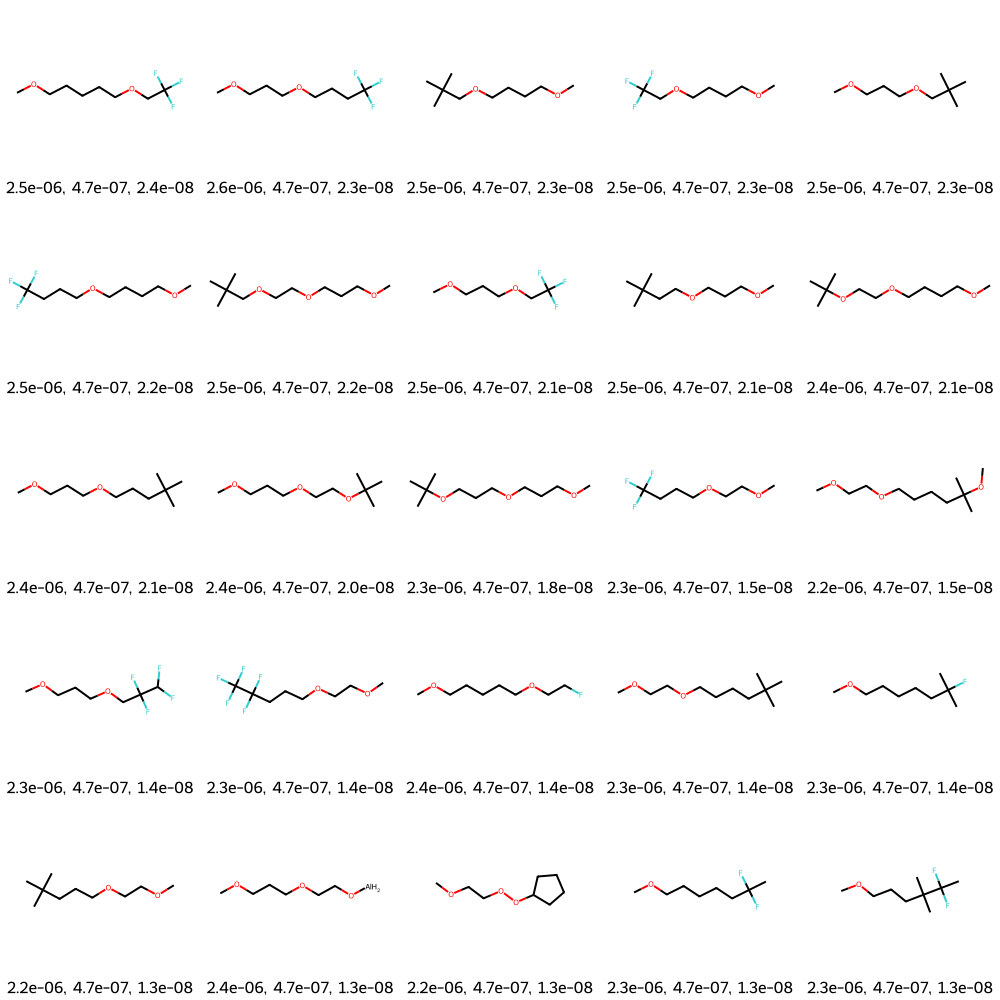

In [45]:
# df_new_['pred_uncertainty'] = df_new_.apply(lambda x: str(round(x['norm_capacity_3_pred'],3)) + ', ' + str(round(x['norm_capacity_3_uncer'],3)) + ', ' + str(round(x['EI_weight_av'],3)), axis=1)
df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
PandasTools.AddMoleculeColumnToFrame(df_new_, smilesCol='solv_comb_sm')
# PandasTools.FrameToGridImage(df_, legendsCol="norm_capacity_3_pred", molsPerRow=6)
PandasTools.FrameToGridImage(df_new_.iloc[:25], legendsCol="pred_comb", molsPerRow=5)

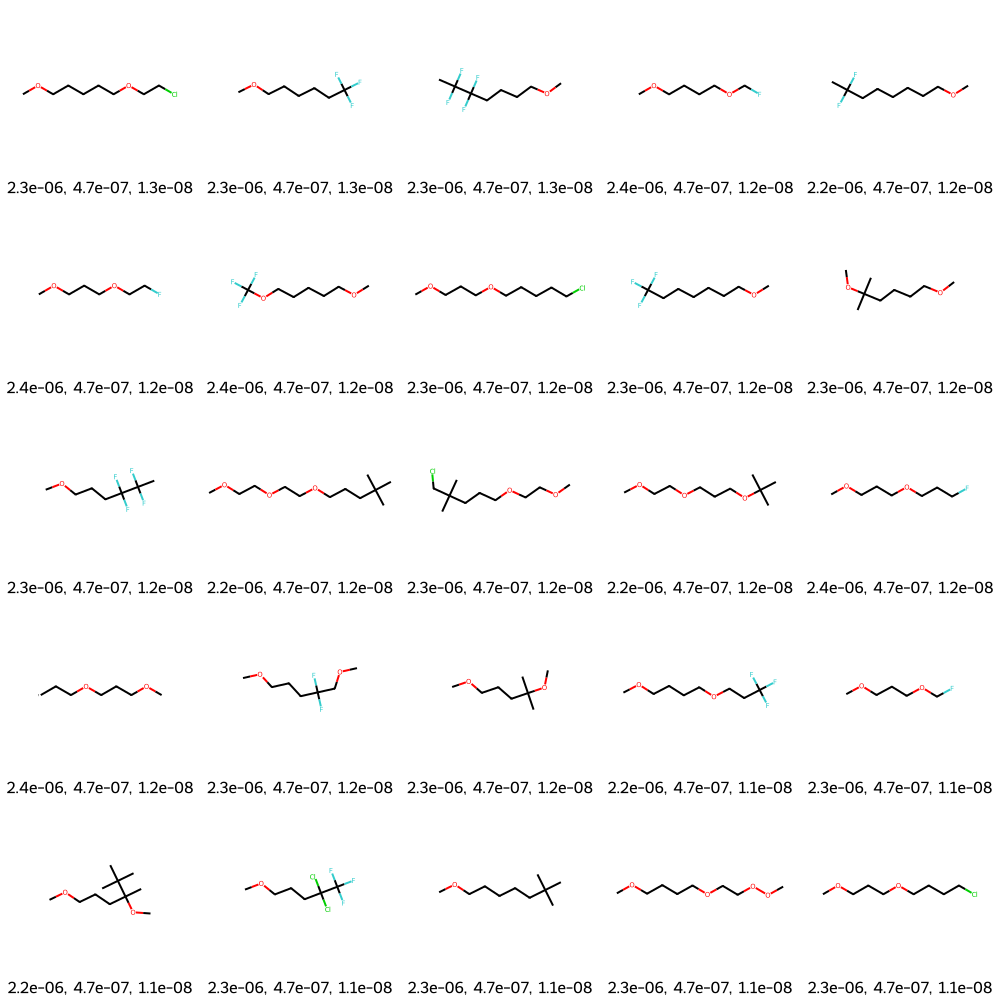

In [46]:
PandasTools.FrameToGridImage(df_new_.iloc[25:50], legendsCol="pred_comb", molsPerRow=5)

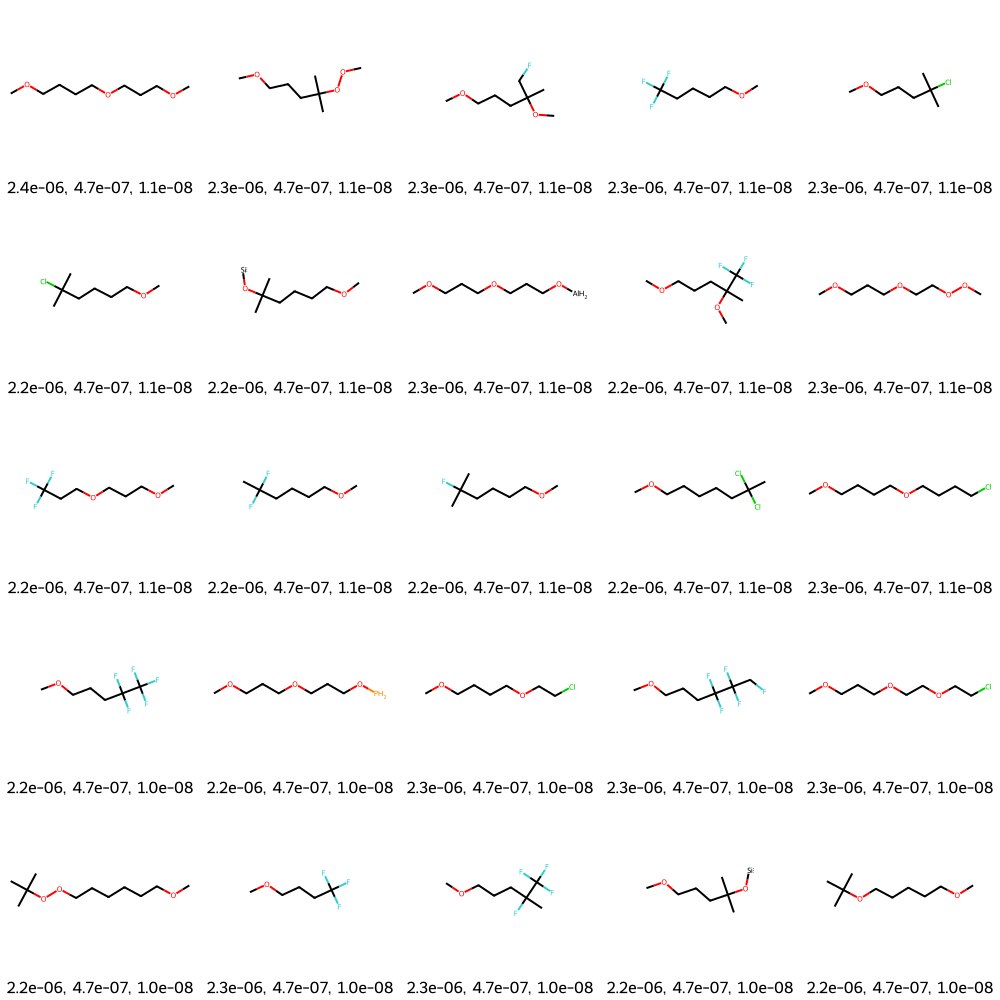

In [47]:
PandasTools.FrameToGridImage(df_new_.iloc[50:75], legendsCol="pred_comb", molsPerRow=5)

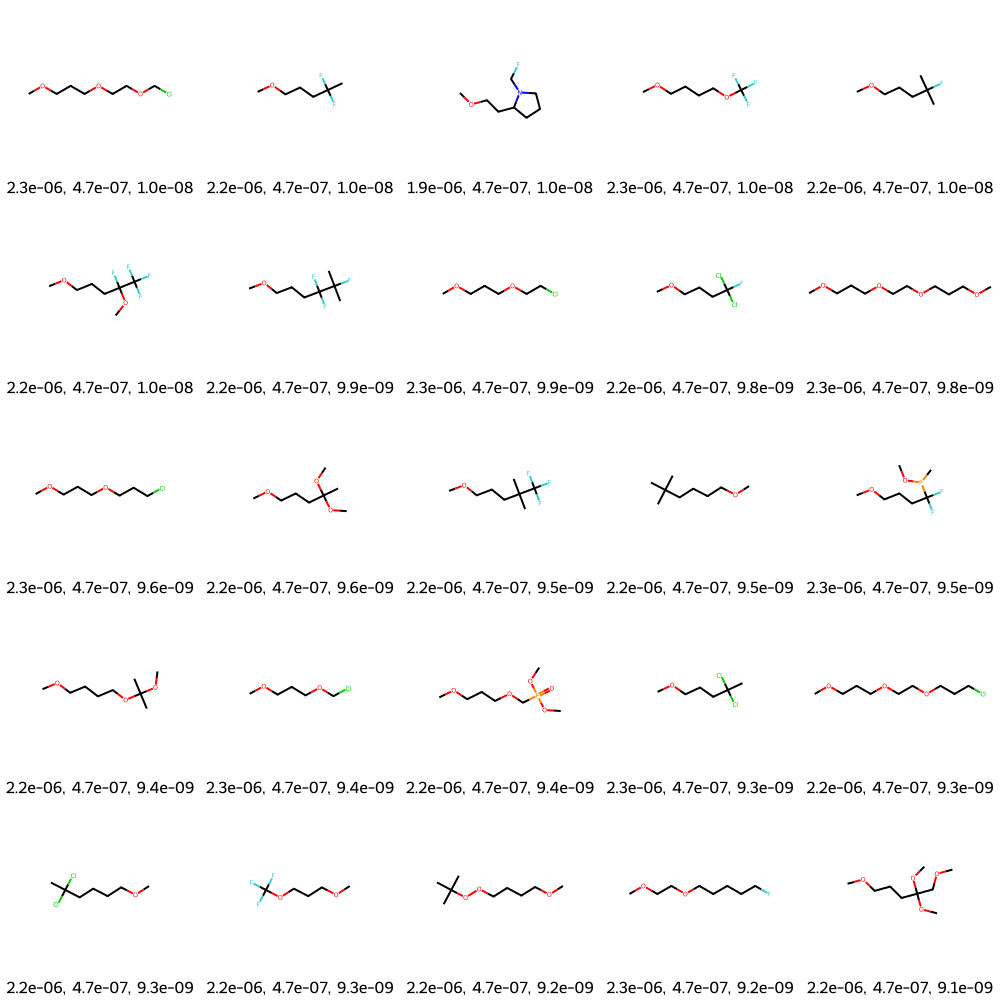

In [48]:
PandasTools.FrameToGridImage(df_new_.iloc[75:100], legendsCol="pred_comb", molsPerRow=5)

In [75]:
%%bash
ls -ltr

total 2677144
-rw-r--r--  1 riteshk  staff  526865388 May 11 13:51 unlabel_1mil_ecfp_pca_add_feat_iter_7.csv
-rw-r--r--@ 1 riteshk  staff      15705 May 11 13:51 just_label_iter_7.csv
-rw-r--r--@ 1 riteshk  staff     941362 May 11 13:57 Activelearning-batch6.xlsx
-rw-r--r--@ 1 riteshk  staff      89674 May 11 14:03 label_ecfp_pca_add_feat_iter_7_051124.csv
-rw-r--r--  1 riteshk  staff     413353 May 11 15:26 pairwise_iter7_051124.pkl
-rw-r--r--  1 riteshk  staff     413328 May 11 15:26 matern_iter7_051124.pkl
-rw-r--r--  1 riteshk  staff     413385 May 11 15:26 rq_iter7_051124.pkl
-rw-r--r--  1 riteshk  staff     413514 May 11 15:26 rbfexpsin_iter7_051124.pkl
-rw-r--r--@ 1 riteshk  staff    1453627 May 11 15:26 sugg_gpr_bma_iter_7.ipynb
-rw-r--r--  1 riteshk  staff  831523447 May 11 15:27 preds_uncer_ei_unlabel_1mil_iter7_051124.csv


**tSNE for top 5000**

In [49]:
## choosing top 5000 after removing Cl-containing compounds since they don't seem to work with AFBs!
print("Total # of Cl-containing compounds:", df_new['solv_comb_sm'].str.contains('Cl').sum())
bool_cl = df_new['solv_comb_sm'].str.contains('Cl').to_list()
cl_ind = df_new[bool_cl].index
mask = pd.Series(True, index=df_new.index)
mask.loc[cl_ind] = False
df_wo_cl = df_new[mask]
df_wo_cl

Total # of Cl-containing compounds: 114572


,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302680,302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,...,0.201637,0.545168,0.171570,0.517962,0.203825,1.696190e-03,4.940562e-03,1.165527e-02,1.359631e-03,2.422279e-08
170076,170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,...,0.199837,0.545271,0.167866,0.549284,0.203073,1.434055e-03,4.412951e-03,1.087684e-02,2.009567e-03,2.343648e-08
261974,261994,262002,262006,262016,262030,COCCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793614,-1.438015,0.929087,...,0.200480,0.547910,0.168968,0.517618,0.203636,1.367006e-03,4.399903e-03,1.146061e-02,1.344834e-03,2.321250e-08
163787,163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,...,0.200511,0.541293,0.169337,0.545572,0.203709,1.489672e-03,4.447878e-03,1.067557e-02,1.952309e-03,2.306165e-08
154948,154964,154971,154974,154981,154991,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.786659,-1.417662,0.909559,...,0.200392,0.543853,0.168540,0.539948,0.203812,1.336109e-03,4.234071e-03,1.083573e-02,1.820138e-03,2.275773e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433423,433459,433474,433483,433501,433523,O=CC1(CCF)CCC(F)(F)C1,[Li+].F[P-](F)(F)(F)(F)F,0.294739,-1.198675,0.575193,...,0.207130,-0.117725,0.180608,-0.180838,0.208198,7.210604e-09,1.550935e-08,4.174167e-08,1.199128e-09,7.787190e-14
398228,398260,398274,398283,398299,398319,O=S1(=O)CCC(F)(F)C1,[Li+].F[P-](F)(F)(F)(F)F,0.534071,-1.136256,0.568939,...,0.203833,-0.098959,0.174729,-0.186963,0.205786,1.219153e-08,2.075621e-08,3.102791e-08,6.918394e-10,7.749745e-14
519584,519621,519637,519647,519666,519690,CC(C)C1(C=O)CCSCC1,[Li+].F[P-](F)(F)(F)(F)F,0.193192,-1.086269,0.373715,...,0.211080,-0.144552,0.187726,-0.225508,0.210240,3.481803e-09,9.803766e-09,5.211224e-08,4.774784e-10,7.638270e-14
443472,443508,443523,443532,443550,443572,O=CC1(C(F)F)CCSCC1,[Li+].F[P-](F)(F)(F)(F)F,0.279085,-1.225040,0.619722,...,0.206217,-0.118189,0.179399,-0.171043,0.207143,9.313734e-09,1.636538e-08,3.476870e-08,1.336368e-09,7.322806e-14


In [50]:
df_new_5000 = df_wo_cl.iloc[:5000,:]
df_new_5000

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302680,302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,...,0.201637,0.545168,0.171570,0.517962,0.203825,0.001696,0.004941,0.011655,0.001360,2.422279e-08
170076,170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,...,0.199837,0.545271,0.167866,0.549284,0.203073,0.001434,0.004413,0.010877,0.002010,2.343648e-08
261974,261994,262002,262006,262016,262030,COCCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793614,-1.438015,0.929087,...,0.200480,0.547910,0.168968,0.517618,0.203636,0.001367,0.004400,0.011461,0.001345,2.321250e-08
163787,163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,...,0.200511,0.541293,0.169337,0.545572,0.203709,0.001490,0.004448,0.010676,0.001952,2.306165e-08
154948,154964,154971,154974,154981,154991,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.786659,-1.417662,0.909559,...,0.200392,0.543853,0.168540,0.539948,0.203812,0.001336,0.004234,0.010836,0.001820,2.275773e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297605,297626,297635,297640,297650,297664,CCCC1N(C)CC(=O)N1CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.234769,-0.934318,0.962222,...,0.224809,0.225026,0.203731,0.222835,0.224837,0.000069,0.000164,0.000406,0.000041,7.254832e-10
147914,147930,147937,147940,147947,147956,CCN1CCCN(CCOC)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.543175,-0.614667,1.028170,...,0.224031,0.211942,0.204031,0.266617,0.223375,0.000092,0.000175,0.000336,0.000076,7.254654e-10
963865,963925,963951,963967,963997,964035,COCCCOCCOCCOCCOCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.769474,-0.981440,0.921684,...,0.217873,0.235127,0.198879,0.275501,0.215363,0.000059,0.000160,0.000384,0.000057,7.253915e-10
49157,49164,49168,49170,49173,49177,COOCCC(C)(OC)OOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.836628,-1.405554,0.932876,...,0.199579,0.317544,0.165570,0.240142,0.204181,0.000077,0.000176,0.000312,0.000015,7.253737e-10


In [ ]:
# df_unlabel_uniq_ = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
# df_unlabel_uniq_

In [51]:
df_comb_tsne = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,-0.272648,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414


In [52]:
list_suggest_bool = df_comb_tsne['solv_comb_sm'].isin(df_new_5000['solv_comb_sm'])
sugg_ind = [i for i in range(len(list_suggest_bool)) if list_suggest_bool[i] == True]
list_label_pool = df_comb_tsne['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
# sugg_ind_1 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2))]
# sugg_ind_2 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2), len(sugg_ind))]
df_comb_tsne['database'] = 'unlabel'
# df_comb_tsne.loc[sugg_ind_1, 'database'] = 'sugg_5th_peiyuan'
# df_comb_tsne.loc[sugg_ind_2, 'database'] = 'sugg_5th_ritesh'
df_comb_tsne.loc[sugg_ind, 'database'] = 'sugg_all'
df_comb_tsne.loc[label_ind, 'database'] = 'label'
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [54]:
len(sugg_ind)
# sugg_ind
# df_comb_tsne['database'].unique()
df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']
# df_comb_tsne.loc[df_comb_tsne['database'] == 'label']

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
427,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,0.755056,0.576431,...,94.043008,186.939685,1.0,0.0,150,50,2,20.200350,24.282938,sugg_all
1155,COCCO[Al],[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.843809,-0.989662,1.069399,-0.365416,-0.311995,0.308275,0.678411,0.599304,...,102.026143,186.939685,1.0,0.0,150,50,2,20.138859,24.319561,sugg_all
1227,COCCB=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801731,-1.105580,1.083006,-0.354707,-0.315271,0.212797,0.668411,0.618927,...,86.053910,186.939685,1.0,0.0,150,50,2,19.959679,23.882128,sugg_all
1319,COCCOOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.867386,-1.041068,1.083540,-0.400942,-0.225466,0.304233,0.783784,0.599485,...,110.037922,186.939685,1.0,0.0,150,50,2,20.315548,24.234709,sugg_all
1382,COCCCC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.046620,-1.064656,0.993638,-0.042687,-0.413475,0.534219,0.629863,0.690217,...,102.068080,186.939685,1.0,0.0,150,50,2,21.194408,28.572851,sugg_all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385578,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,188.141244,144.001775,1.0,0.0,150,50,2,-21.946915,-9.196156,sugg_all
385674,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,170.130680,144.001775,1.0,0.0,150,50,2,-21.917328,-9.234112,sugg_all
385865,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,188.141244,144.001775,1.0,0.0,150,50,2,28.366770,-27.364807,sugg_all
386711,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,185.141579,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_all


cluster regions rather than assigning randomly

In [55]:
df_comb_tsne_sugg = df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']
X_comb_tsne = df_comb_tsne_sugg.iloc[:,-3:-1]
X_comb_tsne

,TSNE_0,TSNE_1
427,20.200350,24.282938
1155,20.138859,24.319561
1227,19.959679,23.882128
1319,20.315548,24.234709
1382,21.194408,28.572851
...,...,...
385578,-21.946915,-9.196156
385674,-21.917328,-9.234112
385865,28.366770,-27.364807
386711,-25.198235,1.801201


In [82]:
kmeans = KMeans(random_state=0).fit(X_comb_tsne) ## using # of clusters found by kmeans method

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

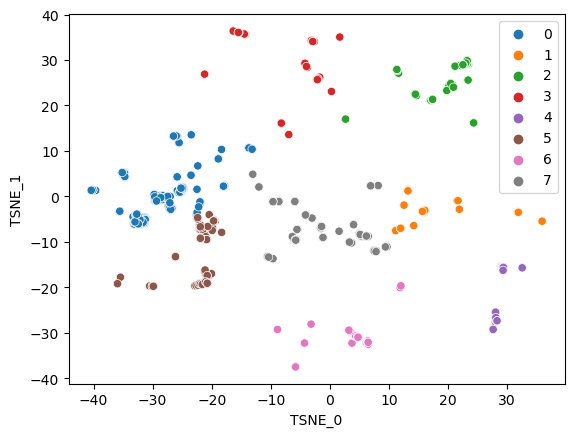

In [83]:
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

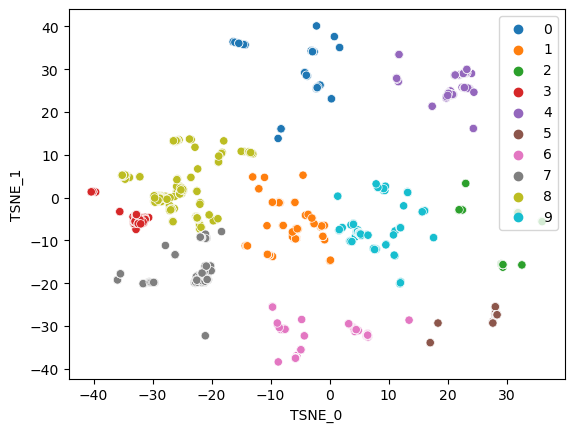

In [56]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_comb_tsne) ## fixing # of clusters to 10
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [57]:
row_label = df_comb_tsne.loc[df_comb_tsne['database'] == 'label']
df_comb_tsne_sugg['database'] = [('sugg_7th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_comb_tsne_ = pd.concat([row_label, df_comb_tsne_sugg], axis=0)
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_3841/21005261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_tsne_sugg['database'] = [('sugg_7th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
1050,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,468.042638,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,99.104799,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label
3279,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,104.083730,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,99.104799,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label
5684,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,88.088815,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385578,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,188.141244,144.001775,1.0,0.0,150,50,2,-21.946915,-9.196156,sugg_7th_7
385674,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,170.130680,144.001775,1.0,0.0,150,50,2,-21.917328,-9.234112,sugg_7th_7
385865,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,188.141244,144.001775,1.0,0.0,150,50,2,28.366770,-27.364807,sugg_7th_5
386711,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,185.141579,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_7th_8


In [58]:
df_new_5000['solv_comb_sm'] = df_new_5000['solv_comb_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df_new_5000

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_3841/4264978177.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_5000['solv_comb_sm'] = df_new_5000['solv_comb_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))


,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
302680,302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,...,0.201637,0.545168,0.171570,0.517962,0.203825,0.001696,0.004941,0.011655,0.001360,2.422279e-08
170076,170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,...,0.199837,0.545271,0.167866,0.549284,0.203073,0.001434,0.004413,0.010877,0.002010,2.343648e-08
261974,261994,262002,262006,262016,262030,COCCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793614,-1.438015,0.929087,...,0.200480,0.547910,0.168968,0.517618,0.203636,0.001367,0.004400,0.011461,0.001345,2.321250e-08
163787,163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,...,0.200511,0.541293,0.169337,0.545572,0.203709,0.001490,0.004448,0.010676,0.001952,2.306165e-08
154948,154964,154971,154974,154981,154991,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.786659,-1.417662,0.909559,...,0.200392,0.543853,0.168540,0.539948,0.203812,0.001336,0.004234,0.010836,0.001820,2.275773e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297605,297626,297635,297640,297650,297664,CCCC1N(C)CC(=O)N1CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.234769,-0.934318,0.962222,...,0.224809,0.225026,0.203731,0.222835,0.224837,0.000069,0.000164,0.000406,0.000041,7.254832e-10
147914,147930,147937,147940,147947,147956,CCN1CCCN(CCOC)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.543175,-0.614667,1.028170,...,0.224031,0.211942,0.204031,0.266617,0.223375,0.000092,0.000175,0.000336,0.000076,7.254654e-10
963865,963925,963951,963967,963997,964035,COCCCOCCOCCOCCOCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.769474,-0.981440,0.921684,...,0.217873,0.235127,0.198879,0.275501,0.215363,0.000059,0.000160,0.000384,0.000057,7.253915e-10
49157,49164,49168,49170,49173,49177,COOCCC(C)(OC)OOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.836628,-1.405554,0.932876,...,0.199579,0.317544,0.165570,0.240142,0.204181,0.000077,0.000176,0.000312,0.000015,7.253737e-10


In [59]:
df_new_5000['rank'] = [i for i in range(1,5001)]
df_comb_tsne_ = df_comb_tsne_.merge(df_new_5000[['solv_comb_sm', 'salt_comb_sm', 'rank']], on=['solv_comb_sm', 'salt_comb_sm'], how='left')
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_3841/694021055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_5000['rank'] = [i for i in range(1,5001)]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,144.001775,1.0,0.0,150,50,2,-21.946915,-9.196156,sugg_7th_7,578.0
4483,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,144.001775,1.0,0.0,150,50,2,-21.917328,-9.234112,sugg_7th_7,4264.0
4484,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,144.001775,1.0,0.0,150,50,2,28.366770,-27.364807,sugg_7th_5,3241.0
4485,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_7th_8,2496.0


In [64]:
df_comb_tsne_.loc[df_comb_tsne_['solv_comb_sm'] == 'COCCOCC(F)(OC)C(F)(F)F']
df_comb_tsne_.loc[df_comb_tsne_['solv_comb_sm'] == 'COCCOCOCCF']
# df_comb_tsne_.loc[df_comb_tsne_['rank'] == 4196]
df_comb_tsne_['rank'].sort_values()
# df_new_5000['rank'].sort_values()
# np.where(df_comb_tsne_['rank'].isna)

3944    1.0
2079    2.0
3309    3.0
1999    4.0
1876    5.0
       ... 
1308    NaN
1825    NaN
2385    NaN
4424    NaN
4452    NaN
Name: rank, Length: 4487, dtype: float64

In [65]:
df_comb_tsne_.to_csv('iter_7_top5000_sugg_ei_unique_explore.csv')

In [66]:
df_comb_tsne['database'].unique()
df_comb_tsne_['database'].unique()
df_comb_tsne_.shape

(4487, 33)

Interactive tSNE plot (Himi's code)

In [67]:
## pick only rows for label, sugg_2nd_peiyuan, and sugg_2nd_ritesh -> not using it but rather clusters from kmeans
# df_comb_tsne__ = df_comb_tsne_.loc[df_comb_tsne['database'] != 'unlabel'] ## somehow this is not working
df_comb_tsne__ = df_comb_tsne_.copy()
df_comb_tsne__

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
2,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,186.939685,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN
3,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
4,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4482,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,144.001775,1.0,0.0,150,50,2,-21.946915,-9.196156,sugg_7th_7,578.0
4483,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,144.001775,1.0,0.0,150,50,2,-21.917328,-9.234112,sugg_7th_7,4264.0
4484,COCCCCCCCOCC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-0.707783,-1.113542,0.971515,0.124799,-0.614998,0.978602,0.770082,0.267719,...,144.001775,1.0,0.0,150,50,2,28.366770,-27.364807,sugg_7th_5,3241.0
4485,COCCC1CCCN(CC=O)C1,[Li+].O=C1O[B-](F)(F)OC1=O,1.183272,-0.146497,0.667712,0.318337,-1.237932,0.317185,1.474304,0.149830,...,144.001775,1.0,0.0,150,50,2,-25.198235,1.801201,sugg_7th_8,2496.0


In [68]:
# df_comb_tsne__['database'].values.tolist()
df_comb_tsne__['database'].unique()

array(['label', 'sugg_7th_4', 'sugg_7th_6', 'sugg_7th_1', 'sugg_7th_0',
       'sugg_7th_7', 'sugg_7th_8', 'sugg_7th_2', 'sugg_7th_3',
       'sugg_7th_9', 'sugg_7th_5'], dtype=object)

In [69]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_comb_tsne__,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_comb_tsne__.solv]
smile = df_comb_tsne__['solv_comb_sm'].values.tolist()
database_class = df_comb_tsne__['database'].values.tolist()
ind = df_comb_tsne__.index.values.tolist()
rank = df_comb_tsne__['rank'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, rank=rank, color=df_comb_tsne__['database'].map({'sugg_7th_0':'cyan', 'sugg_7th_1':'orange', 'sugg_7th_2':'gray',
                                                                                                                                                                                       'sugg_7th_3':'teal', 'sugg_7th_4':'green', 'sugg_7th_5':'yellow', 
                                                                                                                                                                                       'sugg_7th_6':'red', 'sugg_7th_7':'purple', 'sugg_7th_8':'lime',
                                                                                                                                                                                       'sugg_7th_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @rank </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 from model)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_051124_explore.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-7/interactive_map_sugg_al_051124_explore.html'

**Finding from top 5000 predictions: exploit**

In [70]:
df_exploit = df_unlabel_.copy()
df_exploit['norm_capacity_3_avg_pred'] = df_exploit[['norm_capacity_3_pair', 'norm_capacity_3_matern', 'norm_capacity_3_rq', 'norm_capacity_3_rbfexpsin']].mean(axis=1)
bool_cl_exp = df_exploit['solv_comb_sm'].str.contains('Cl').to_list()
cl_ind_exp = df_exploit[bool_cl_exp].index
mask_exp = pd.Series(True, index=df_exploit.index)
mask_exp.loc[cl_ind_exp] = False
df_exploit_wo_cl = df_exploit[mask_exp]
df_exploit_wo_cl

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,norm_capacity_3_avg_pred
0,0,0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,...,0.037666,0.192014,-0.054267,0.217417,5.558162e-07,1.240826e-06,0.000007,9.670306e-08,9.654864e-12,-0.011331
1,1,1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,...,-0.003274,0.203546,-0.001456,0.226214,1.075332e-06,1.891838e-06,0.000007,7.229094e-07,1.160980e-11,-0.010513
2,2,2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,...,-0.047665,0.209669,-0.162093,0.227823,1.044421e-07,3.739091e-07,0.000005,2.640350e-08,5.514583e-12,-0.118091
3,3,3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,...,0.096361,0.178639,0.059433,0.209897,2.954488e-06,4.279159e-06,0.000008,5.715265e-07,1.833054e-11,0.082888
4,4,4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,...,0.025149,0.196441,-0.091247,0.219417,4.897230e-07,1.155365e-06,0.000007,5.155232e-08,1.000300e-11,-0.031123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999821,999882,999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,...,-0.105749,0.224092,-0.245697,0.237513,3.898570e-08,3.090369e-07,0.000005,1.217796e-08,4.965443e-12,-0.187580
999822,999883,999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,...,-0.066847,0.239166,-0.056383,0.248100,4.190717e-07,3.851784e-06,0.000025,1.544176e-06,2.846834e-11,-0.088684
999823,999884,999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,...,-0.051867,0.230982,-0.089544,0.243065,3.834876e-07,2.683026e-06,0.000020,5.546731e-07,2.216600e-11,-0.086094
999824,999885,999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,...,-0.087810,0.249035,-0.192402,0.257395,4.490211e-08,1.769142e-06,0.000031,2.713660e-07,2.954952e-11,-0.185245


In [71]:
df_exploit_5000 = df_exploit_wo_cl.sort_values(by=['norm_capacity_3_avg_pred'], ascending=False).iloc[:5000,:]
df_exploit_5000['rank'] = [i for i in range(1,5001)]
df_exploit_5000

,index_4,index_3,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,...,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,norm_capacity_3_avg_pred,rank
170076,170094,170101,170104,170112,170122,COCCCOCCCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.769783,-1.490721,0.862885,...,0.167866,0.549284,0.203073,0.001434,0.004413,0.010877,0.002010,2.343648e-08,0.535321,1
163787,163805,163812,163815,163823,163833,COCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.740833,-1.411703,0.814934,...,0.169337,0.545572,0.203709,0.001490,0.004448,0.010676,0.001952,2.306165e-08,0.533883,2
302680,302701,302710,302715,302726,302740,COCCCCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.801624,-1.450690,0.826390,...,0.171570,0.517962,0.203825,0.001696,0.004941,0.011655,0.001360,2.422279e-08,0.532022,3
154948,154964,154971,154974,154981,154991,COCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.786659,-1.417662,0.909559,...,0.168540,0.539948,0.203812,0.001336,0.004234,0.010836,0.001820,2.275773e-08,0.529714,4
261974,261994,262002,262006,262016,262030,COCCCCOCC(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.793614,-1.438015,0.929087,...,0.168968,0.517618,0.203636,0.001367,0.004400,0.011461,0.001345,2.321250e-08,0.526424,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262283,262303,262311,262315,262325,262339,COCCCOCCCC(=O)C(C)(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.056247,-0.101243,1.279981,...,0.190983,0.281103,0.212861,0.000063,0.000168,0.000491,0.000054,8.805505e-10,0.272041,4996
17288,17289,17291,17292,17293,17295,CCOP(=O)(OCC)OCC(C)(C)COC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.003716,-1.090308,0.969682,...,0.170233,0.242811,0.203493,0.000039,0.000117,0.000318,0.000015,6.098457e-10,0.272030,4997
43105,43111,43115,43117,43119,43123,COCC(OC)(OC=O)OC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.838175,-0.847159,1.135963,...,0.161836,0.266177,0.199026,0.000027,0.000080,0.000182,0.000017,3.957002e-10,0.272028,4998
65864,65872,65877,65879,65883,65888,CCP(=O)(OC)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.835452,-1.199883,0.893429,...,0.163275,0.281870,0.199743,0.000029,0.000077,0.000154,0.000024,3.612868e-10,0.272018,4999


In [72]:
df_tsne_exploit = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
list_exploit_bool = df_tsne_exploit['solv_comb_sm'].isin(df_exploit_5000['solv_comb_sm'])
exploit_ind = [i for i in range(len(list_exploit_bool)) if list_exploit_bool[i] == True]
list_label_pool = df_tsne_exploit['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
df_tsne_exploit['database'] = 'unlabel'
df_tsne_exploit.loc[exploit_ind, 'database'] = 'exploit'
df_tsne_exploit.loc[label_ind, 'database'] = 'label'
df_tsne_exploit

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [73]:
df_tsne_exploit_sugg = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'exploit']
# X_tsne_exploit = df_tsne_exploit_sugg.iloc[:,-3:-1]
# kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne_exploit) ## using # of clusters found by kmeans method
# sns.scatterplot(x=df_tsne_exploit_sugg['TSNE_0'], y=df_tsne_exploit_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [74]:
# df_tsne_exploit_sugg['norm_capacity_3_avg_pred'] = df_exploit_10000['norm_capacity_3_avg_pred']
df_tsne_exploit_sugg = df_tsne_exploit_sugg.merge(df_exploit_5000[['solv_comb_sm', 'norm_capacity_3_avg_pred', 'rank']], on='solv_comb_sm', how='left')
df_tsne_exploit_sugg

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred,rank
0,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,0.755056,0.576431,...,1.0,0.0,150,50,2,20.200350,24.282938,exploit,0.361556,963
1,CCCOOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.920924,-1.603036,0.550274,0.249128,-0.250719,0.486272,0.282188,0.202565,...,1.0,0.0,150,50,2,1.736852,34.990818,exploit,0.272308,4969
2,[CH2]CCOOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.653605,-1.424194,0.878123,-0.406314,-0.163474,0.121483,0.449710,0.405105,...,1.0,0.0,150,50,2,-20.417168,-4.034942,exploit,0.319932,2059
3,COP(=O)(OC)OCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.621001,-1.115459,1.065245,-0.408802,0.071975,0.005767,0.326389,0.238781,...,1.0,0.0,150,50,2,-8.799691,-38.527060,exploit,0.282854,4145
4,CCOP(=O)(OCC)OCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.104998,-0.671211,1.004061,0.135798,-0.179604,0.467863,0.406747,0.484254,...,1.0,0.0,150,50,2,28.083122,-25.441036,exploit,0.276050,4683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,COCCCS(C)(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.854245,-1.533978,0.921179,-0.305305,-0.172969,0.520020,1.193371,0.510727,...,1.0,0.0,150,50,2,31.906532,-3.521527,exploit,0.279934,4361
4992,CCCOCCOCCCOCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.877738,-1.596169,0.522391,0.412222,-0.835663,1.200644,0.817318,0.236686,...,1.0,0.0,150,50,2,-35.143620,5.230699,exploit,0.286137,3905
4993,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,1.0,0.0,150,50,2,-21.946915,-9.196156,exploit,0.341674,1358
4994,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,1.0,0.0,150,50,2,-21.917328,-9.234112,exploit,0.281449,4240


/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

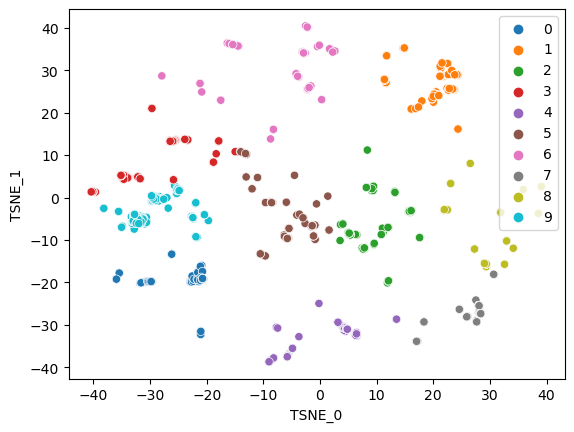

In [75]:
X_tsne_exploit = df_tsne_exploit_sugg.iloc[:,-5:-3]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne_exploit) ## using # of clusters found by kmeans method
sns.scatterplot(x=df_tsne_exploit_sugg['TSNE_0'], y=df_tsne_exploit_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [76]:
row_label = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'label']
df_tsne_exploit_sugg['database'] = [('exploit_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_tsne_exploit_ = pd.concat([row_label, df_tsne_exploit_sugg], axis=0)
df_tsne_exploit_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred,rank
1050,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN,NaN
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN,NaN
3279,CCOCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.084384,-1.014022,0.862732,0.014255,-0.374000,0.614768,0.628171,0.548904,...,1.0,0.0,150,50,2,22.556498,28.949097,label,NaN,NaN
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN,NaN
5684,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,COCCCS(C)(C)C,[Li+].O=C1O[B-](F)(F)OC1=O,-0.854245,-1.533978,0.921179,-0.305305,-0.172969,0.520020,1.193371,0.510727,...,1.0,0.0,150,50,2,31.906532,-3.521527,exploit_8,0.279934,4361.0
4992,CCCOCCOCCCOCCCOC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.877738,-1.596169,0.522391,0.412222,-0.835663,1.200644,0.817318,0.236686,...,1.0,0.0,150,50,2,-35.143620,5.230699,exploit_3,0.286137,3905.0
4993,COCCOCCOC1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.340693,-0.507196,0.871490,-0.409964,-1.059248,1.172802,0.773990,-0.333313,...,1.0,0.0,150,50,2,-21.946915,-9.196156,exploit_9,0.341674,1358.0
4994,COCCC1CCCC(=O)CC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.631822,-0.656586,1.123381,-0.360369,-0.423082,0.714197,0.992159,-0.337507,...,1.0,0.0,150,50,2,-21.917328,-9.234112,exploit_9,0.281449,4240.0


In [77]:
len(kmeans.labels_)
# len(row_label)

4996

In [78]:
df_tsne_exploit_['norm_capacity_3_avg_pred']

1050         NaN
2373         NaN
3279         NaN
4139         NaN
5684         NaN
          ...   
4991    0.279934
4992    0.286137
4993    0.341674
4994    0.281449
4995    0.292158
Name: norm_capacity_3_avg_pred, Length: 5137, dtype: float64

In [79]:
df_tsne_exploit_.to_csv('iter_7_top5000_sugg_ei_unique_exploit.csv', index=False)

In [80]:
df_tsne_exploit_['database'].unique()

array(['label', 'exploit_1', 'exploit_6', 'exploit_9', 'exploit_4',
       'exploit_7', 'exploit_8', 'exploit_5', 'exploit_0', 'exploit_2',
       'exploit_3'], dtype=object)

In [81]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_tsne_exploit_,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_tsne_exploit_.solv]
smile = df_tsne_exploit_['solv_comb_sm'].values.tolist()
database_class = df_tsne_exploit_['database'].values.tolist()
ind = df_tsne_exploit_.index.values.tolist()
pred = ([0.0]*110) + [round(val, 3) for val in df_tsne_exploit_['norm_capacity_3_avg_pred'].iloc[110:].values.tolist()]
rank = df_tsne_exploit_['rank'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_tsne_exploit_['TSNE_0'], y=df_tsne_exploit_['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, pred=pred, rank=rank, color=df_tsne_exploit_['database'].map({'exploit_0':'cyan', 'exploit_1':'orange', 'exploit_2':'gray',
                                                                                                                                                                                       'exploit_3':'teal', 'exploit_4':'green', 'exploit_5':'yellow', 
                                                                                                                                                                                       'exploit_6':'red', 'exploit_7':'purple', 'exploit_8':'lime',
                                                                                                                                                                                       'exploit_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Prediction: @pred </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @rank </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 predictions)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_7_051124_exploit.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-7/interactive_map_sugg_al_7_051124_exploit.html'